In [1]:
import numpy as np
import dipy, dipy.data
import random
import matplotlib.pyplot as plt
import torch

In [2]:
%matplotlib inline

## Download exemplary diffusion data from dipy

In [3]:
hardi_fname, hardi_bval_fname, hardi_bvec_fname = dipy.data.get_fnames('stanford_hardi')

## A very simple dataloader

This dataloader will return 50 3D patches (48x48x48) with 150 feature maps. This data will be used to showcase the Models Genesis transforms. If you are only interested in those, you can jump to the next section.

In [4]:
from rising.loading import Dataset

In [5]:
class StanfordHardiDataset(Dataset):
    def __init__(self, hardi_fname, hardi_bval_fname, hardi_bvec_fname):
        data, affine = dipy.io.image.load_nifti(hardi_fname)

        bvals, bvecs = dipy.io.gradients.read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
        gtab = dipy.core.gradients.gradient_table(bvals, bvecs)
        
        mean_b0 = data[...,gtab.bvals == 0].mean(axis=-1, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            edw = np.divide(data, mean_b0)
        edw[~np.isfinite(edw)] = 0
        edw = np.clip(edw,0,1)
        edw = edw[...,gtab.bvals!=0]
        
        self.patches = self.random_patches(edw)
        
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        return (self.patches[idx], self.patches[idx])
    
    def random_patches(self, edw, n_patches=50):
        s = edw.shape[:3]
        patch_size = 48
        ps2 = np.int(patch_size / 2)

        torch_patches = []

        for n in range(n_patches):
            x = random.randint(ps2,s[0]-ps2)
            y = random.randint(ps2,s[1]-ps2)
            z = random.randint(ps2,s[2]-ps2)

            patch = edw[x-ps2:x+ps2,y-ps2:y+ps2,z-ps2:z+ps2,:]
            patch = np.moveaxis(patch, 3, 0)
            patch = patch

            torch_patches.append(torch.from_numpy(patch).type(torch.FloatTensor))

        return torch_patches

# Models Genesis Transformations

The following transforms were proposed by Zhou et al., (https://arxiv.org/abs/1908.06912), and are known as Models Genesis: Generic Autodidactic Models for 3D Medical Image Analysis.  
This is an inofficial reimplementation in the *rising* framework, without any guarantee for correctness and/or exact reimplementation of the original transforms
 

In [6]:
from rising.loading import DataLoader, default_transform_call
import rising.transforms as rtr
from rising.random import DiscreteCombinationsParameter

In [7]:
dMRIdataset = StanfordHardiDataset(hardi_fname, hardi_bval_fname, hardi_bvec_fname)

*dMRIdataset* returns a sequence, containing two times the same 3D patch. One of those will be distorted, the other one will be left pristine, so that the final network will be able to learn the mapping from the distorted to the original patch. The different transformations are independently usable, you should choose those that are sensible for your project.

Note: for the RandomBezierTransform, you will need to install https://github.com/aliutkus/torchsearchsorted

In [8]:
# This function will later be used to visualize the results of the transforms
def visualize_pair(pair):
    plt.rcParams['figure.figsize'] = [10,15]
    img_d = pair['distorted']
    img_p = pair['pristine']
    s = img_p.shape
    x,y,z,n = random.randint(0,s[2]-1),random.randint(0,s[3]-1), \
                random.randint(0,s[4]-1),random.randint(0,s[2]-1)
    x,y,z = 24,24,24
    plt.figure()
    kwargs = {"cmap": 'gray', "vmin": 0, "vmax": 1}
    plt.subplot(3, 3, 1)
    plt.axis("off")
    plt.title("Pristine", fontsize=20)
    plt.imshow(img_p[0, n, x, :, :], **kwargs)
    plt.subplot(3, 3, 2)
    plt.axis("off")
    plt.title("Distorted", fontsize=20)
    plt.imshow(img_d[0, n, x, :, :], **kwargs)
    plt.subplot(3, 3, 3)
    plt.axis("off")
    plt.title("Difference", fontsize=20)
    plt.imshow(img_d[0, n, x, :, :] - img_p[0, n, x, :, :] + 0.5, **kwargs)
    
    plt.subplot(3, 3, 4)
    plt.axis("off")
    plt.imshow(img_p[0, n, :, y, :], **kwargs)
    plt.subplot(3, 3, 5)
    plt.axis("off")
    plt.imshow(img_d[0, n, :, y, :], **kwargs)
    plt.subplot(3, 3, 6)
    plt.axis("off")
    plt.imshow(img_d[0, n, :, y, :] - img_p[0, n, :, y, :] + 0.5, **kwargs)
    
    plt.subplot(3, 3, 7)
    plt.axis("off")
    plt.imshow(img_p[0, n, :, :, z], **kwargs)
    plt.subplot(3, 3, 8)
    plt.axis("off")
    plt.imshow(img_d[0, n, :, :, z], **kwargs)
    plt.subplot(3, 3, 9)
    plt.axis("off")
    plt.imshow(img_d[0, n, :, :, z] - img_p[0, n, :, :, z] + 0.5, **kwargs)
    
    plt.show()

## Non-linear transform

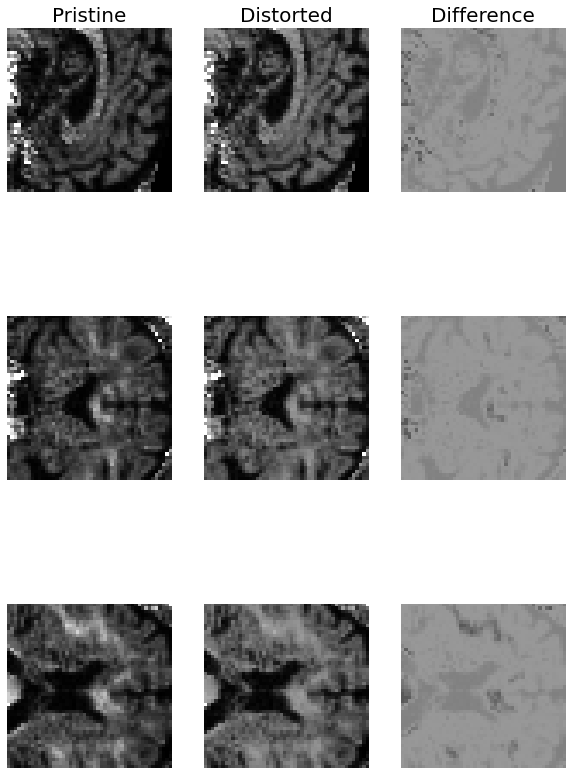

In [9]:
transforms = [
    rtr.SeqToMap("distorted", "pristine"),
    rtr.intensity.RandomBezierTransform(keys=("distorted",)),
             ]

dl_train = DataLoader(dMRIdataset, batch_size=3, 
                      batch_transforms=rtr.Compose(transforms, transform_call=default_transform_call))

visualize_pair(next(iter(dl_train)))

## Non-linear transform with inversion

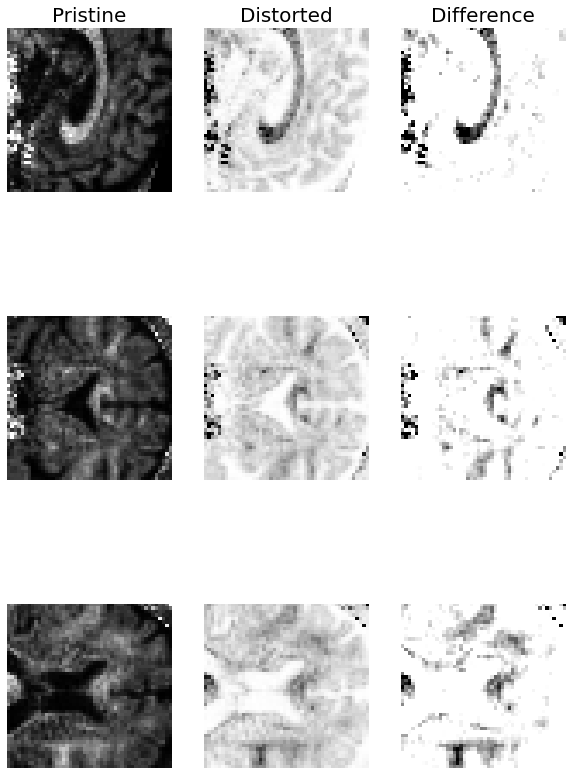

In [10]:
transforms = [
    rtr.SeqToMap("distorted", "pristine"),
    rtr.intensity.RandomBezierTransform(keys=("distorted",)),
    rtr.intensity.InvertAmplitude(prob=1.0, keys=("distorted",)),
             ]

dl_train = DataLoader(dMRIdataset, batch_size=3, 
                      batch_transforms=rtr.Compose(transforms, transform_call=default_transform_call))

visualize_pair(next(iter(dl_train)))

## Random pixel shuffle transform

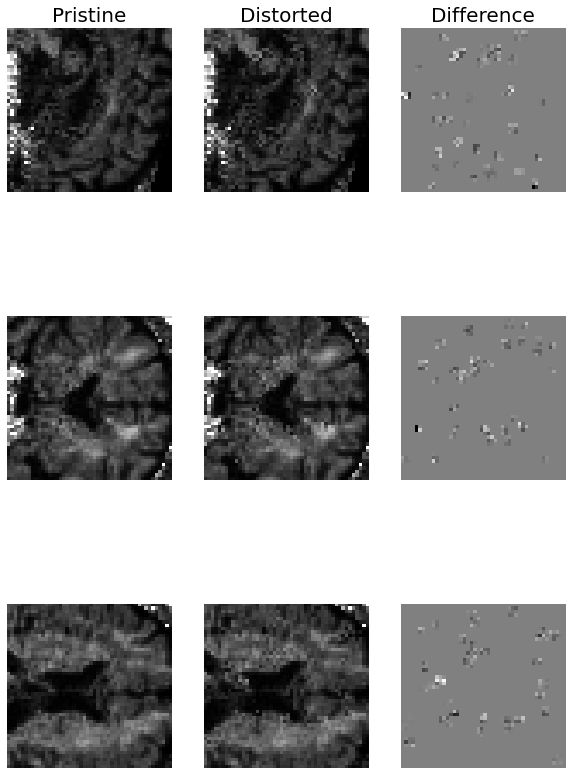

In [11]:
transforms = [
    rtr.SeqToMap("distorted", "pristine"),
    rtr.painting.LocalPixelShuffle(n=100000, keys=("distorted",)),
             ]

dl_train = DataLoader(dMRIdataset, batch_size=3, 
                      batch_transforms=rtr.Compose(transforms, transform_call=default_transform_call))

visualize_pair(next(iter(dl_train)))

## Outpainting

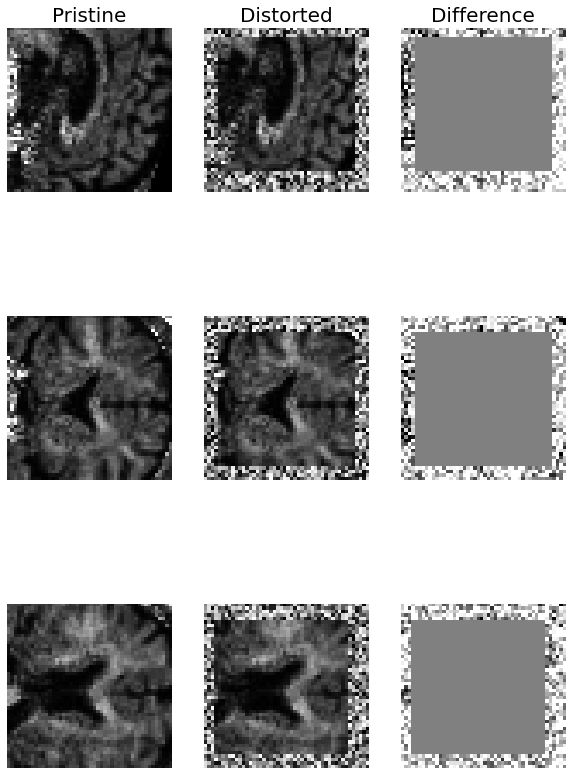

In [12]:
transforms = [
    rtr.SeqToMap("distorted", "pristine"),
    rtr.painting.RandomOutpainting(prob=1.0, keys=("distorted",)),
             ]

dl_train = DataLoader(dMRIdataset, batch_size=3, 
                      batch_transforms=rtr.Compose(transforms, transform_call=default_transform_call))

visualize_pair(next(iter(dl_train)))

## Inpainting

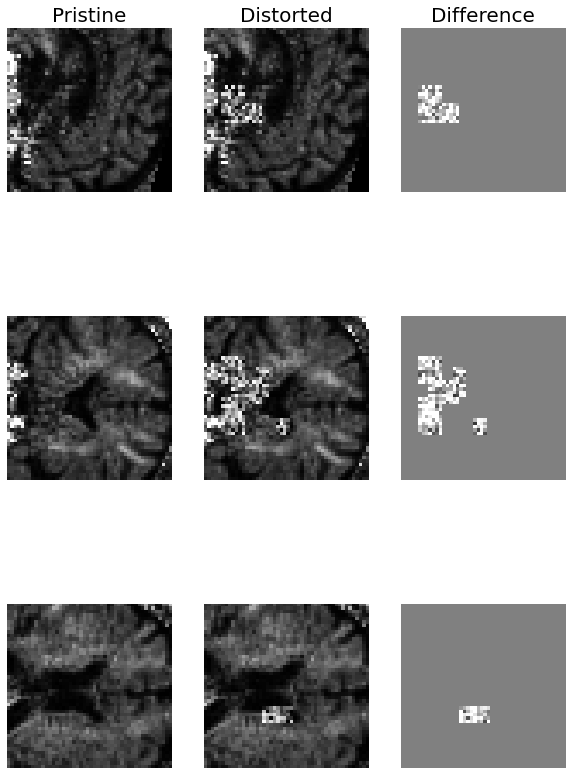

In [29]:
transforms = [
    rtr.SeqToMap("distorted", "pristine"),
    rtr.painting.RandomInpainting(n=50, keys=("distorted",)),
             ]

dl_train = DataLoader(dMRIdataset, batch_size=3, 
                      batch_transforms=rtr.Compose(transforms, transform_call=default_transform_call))

visualize_pair(next(iter(dl_train)))

## All put together

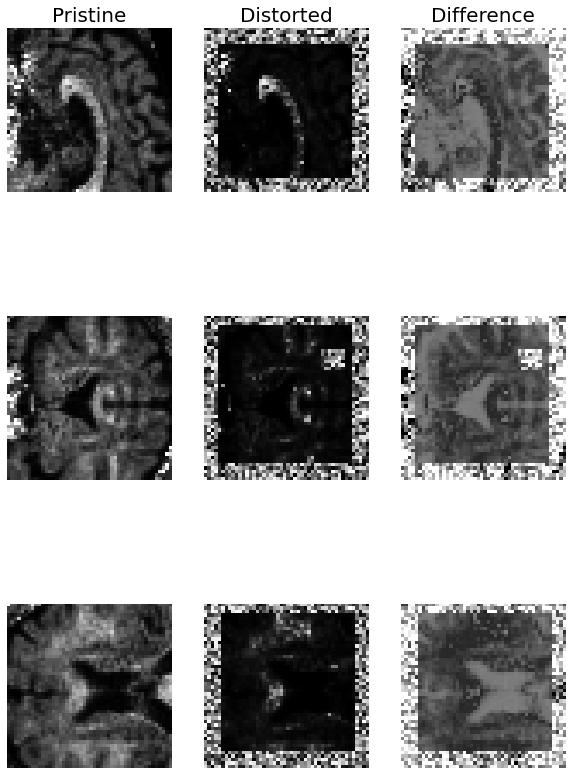

In [30]:
transforms = [
    rtr.SeqToMap("distorted", "pristine"),
    rtr.spatial.Mirror(dims=(1,), prob=0.5, keys=("distorted", "pristine")),
    rtr.intensity.RandomBezierTransform(keys=("distorted",)),
    rtr.intensity.InvertAmplitude(prob=0.1, keys=("distorted",)),
    rtr.painting.RandomOutpainting(prob=0.4, keys=("distorted",)),
    rtr.painting.RandomInpainting(n=5, keys=("distorted",)),
             ]

dl_train = DataLoader(dMRIdataset, batch_size=3, 
                      batch_transforms=rtr.Compose(transforms, transform_call=default_transform_call))

visualize_pair(next(iter(dl_train)))